# Simple AutoML for time series with Ray AIR

In [1]:
!pip install statsforecast

In [2]:
from typing import List, Union, Callable, Dict, Type, Tuple
import time
import itertools
import pandas as pd
import numpy as np
from collections import defaultdict
from statsforecast import StatsForecast
from statsforecast.models import ETS, AutoARIMA, _TS
from pyarrow import parquet as pq
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import ray
from ray import air, tune
from ray.train.statsforecast.statsforecast_trainer import StatsforecastTrainer

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env={"pip": ["statsforecast"]})

2022-10-20 17:44:18,450	INFO worker.py:1229 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-10-20 17:44:20,410	INFO worker.py:1341 -- Connecting to existing Ray cluster at address: 172.31.111.100:9031...
2022-10-20 17:44:20,420	INFO worker.py:1518 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_J737nkSmzssxqHpQ2RQREEaP/services?redirect_to=dashboard 
2022-10-20 17:44:20,987	INFO packaging.py:527 -- Creating a file package for local directory '/tmp/ray_tmp_module/ray'.
2022-10-20 17:44:20,988	WARNING packaging.py:401 -- File /tmp/ray_tmp_module/ray/jars/ray_dist.jar is very large (30.02MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/tmp/ray_tmp_module/ray/jars/ray_dist.jar']})`
2022-10-20 17:44:21,532	WARNING packaging.py:401 -- File /tmp/ray_tmp_module/ray/core/src/ray/raylet/raylet is very large (18.87MiB). Consider adding

Python version:,3.8.13
Ray version:,3.0.0.dev0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_J737nkSmzssxqHpQ2RQREEaP/services?redirect_to=dashboard


## Read the dataset from S3 using `ray.data`

```diff
- TODO: use ray.data.read_parquet
```

In [4]:
# def get_tourism_data(unique_id: str) -> ray.data.Dataset:
#     data_url = "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv"
#     tourism_df = pd.read_csv(data_url, sep=",")

#     # Aggregate
#     target_var = "Trips"
#     aggregation_vars = ["Quarter", "State"] 
#     tourism_df_agg = tourism_df[aggregation_vars + [target_var]].groupby(aggregation_vars, as_index=False).sum()

#     # Create a dict maping string values in Quarter to datetime
#     quarters = tourism_df["Quarter"].sort_values().unique()
#     ds = pd.date_range(start='1998-01-01', periods=len(quarters), freq='Q')
#     ds_quarter = dict(zip(quarters, ds))

#     # Prepare columns
#     tourism_df_agg.rename(columns={target_var: 'y'}, inplace=True)
#     tourism_df_agg["unique_id"] = tourism_df_agg.groupby("State").ngroup()
#     tourism_df_agg["ds"] = [ds_quarter[q] for q in tourism_df_agg["Quarter"]]

# #     State_id = dict(zip(tourism_df_agg["unique_id"].unique(), tourism_df_agg["State"].unique()))
#     tourism_df_agg.drop(["Quarter", "State"], axis=1, inplace=True)

#     tourism_df_agg = tourism_df_agg[tourism_df_agg.unique_id == unique_id]
#     return ray.data.from_pandas(tourism_df_agg)

In [5]:
# ds = get_tourism_data(0)

In [6]:
from typing import List

def get_m5_partition(unique_ids: List[str]) -> ray.data.Dataset:
    ds1 = pq.read_table(
        "s3://anonymous@m5-benchmarks/data/train/target.parquet",
        filters=[("item_id", "in", unique_ids)],
#         filters=[("item_id", "=", unique_id)],
    )
    Y_df = ds1.to_pandas()
    # StatsForecasts expects specific column names!
    Y_df = Y_df.rename(
        columns={"item_id": "unique_id", "timestamp": "ds", "demand": "y"}
    )
    Y_df["unique_id"] = Y_df["unique_id"].astype(str)
    Y_df["ds"] = pd.to_datetime(Y_df["ds"])
    Y_df = Y_df.dropna()
    constant = 10
    Y_df["y"] += constant
    print(Y_df["unique_id"].unique())
    return ray.data.from_pandas(Y_df)

In [16]:
partition_ids = [
    'FOODS_1_001_CA_1', 'FOODS_1_001_CA_2', 'FOODS_1_001_CA_3', 'FOODS_1_001_CA_4', 'FOODS_1_001_TX_1'
]

In [ ]:
ds = get_m5_partition(partition_ids)
ds

## Define the search space

In [8]:
search_space = {
    AutoARIMA: {},
    ETS: {
        "season_length": [6, 7],
        "model": ["ZNA", "ZZZ"],
    }
}

def generate_configurations(search_space):
    for model, params in search_space.items():
        if not params:
            yield model, {}
        else:
            configurations = itertools.product(*params.values())
            for config in configurations:
                config_dict = {k: v for k, v in zip(params.keys(), config)}
                yield model, config_dict

configs = list(generate_configurations(search_space))

## Create a `statsforecast` AIR Trainer

In [9]:
statsforecast_trainer = StatsforecastTrainer(
    datasets={"train": ds},
    return_train_forecasts_cv=True,
    scaling_config=air.ScalingConfig(
        trainer_resources={"CPU": 3}
    ),
)

## Create a Tuner and specify a grid search

In [ ]:
tuner = tune.Tuner(
    statsforecast_trainer,
    param_space={
        "model_cls_and_params": tune.grid_search(configs),
        "n_splits": 5,
        "test_size": 1,
        "freq": "D",
    },
#     tune_config=tune.TuneConfig(
#     ),
)
result_grid = tuner.fit()

In [17]:
# Get the best model for each data partition
results_df = result_grid.get_dataframe()
for unique_id in partition_ids:
    min_idx = results_df[f"{unique_id}/mse_mean"].argmin()
    print(f"Best model and params for series with id = {unique_id}:")
    best_result_for_series = result_grid[min_idx]
    print(best_result_for_series.config["model_cls_and_params"])
    print(best_result_for_series.metrics[f"{unique_id}/mse_mean"])

Best model and params for series with id = FOODS_1_001_CA_1:
(<class 'statsforecast.models.ETS'>, {'season_length': 6, 'model': 'ZNA'})
0.64205205
Best model and params for series with id = FOODS_1_001_CA_2:
(<class 'statsforecast.models.ETS'>, {'season_length': 7, 'model': 'ZNA'})
0.6388546
Best model and params for series with id = FOODS_1_001_CA_3:
(<class 'statsforecast.models.ETS'>, {'season_length': 7, 'model': 'ZNA'})
0.9547448
Best model and params for series with id = FOODS_1_001_CA_4:
(<class 'statsforecast.models.ETS'>, {'season_length': 7, 'model': 'ZNA'})
0.24473815
Best model and params for series with id = FOODS_1_001_TX_1:
(<class 'statsforecast.models.ETS'>, {'season_length': 6, 'model': 'ZNA'})
1.1727684


In [25]:
best_result = result_grid.get_best_result()

print("Best config:", best_result.config)
print("Best mse_mean:", best_result.metrics["mse_mean"])
print("Best mae_mean:", best_result.metrics["mae_mean"])

Best config: {'model_cls_and_params': (<class 'statsforecast.models.ETS'>, {'season_length': 6, 'model': 'ZZZ'}), 'n_splits': 20, 'test_size': 1, 'freq': 'D'}
Best mse_mean: 2.4466078
Best mae_mean: 1.1771317


In [27]:
best_model_cls, best_model_params = best_result.config["model_cls_and_params"]
print("Best model type:", best_model_cls)
print("Best model params:", best_model_params)
best_result.metrics_dataframe

Best model type: <class 'statsforecast.models.ETS'>
Best model params: {'season_length': 6, 'model': 'ZZZ'}


,mse,mae,mse_mean,mse_std,mae_mean,mae_std,cutoff_values,cv_time,time_this_iter_s,should_checkpoint,...,timesteps_since_restore,iterations_since_restore,warmup_time,train/mse,train/mae,train/mse_mean,train/mse_std,train/mae_mean,train/mae_std,train/cutoff_values
0,"[26.65016, 0.012066378, 1.2185614, 3.8180134, ...","[5.1623793, 0.10984707, 1.1038847, 1.9539738, ...",2.446608,5.642607,1.177132,1.030033,['2016-05-02T00:00:00.000000000' '2016-05-03T0...,95.721762,95.931287,True,...,0,1,0.005811,"[1.52105, 1.5338982, 1.5330831, 1.5328774, 1.5...","[0.8294641, 0.83179885, 0.83143866, 0.8315958,...",1.533056,0.00323,0.832982,0.001222,['2016-05-02T00:00:00.000000000' '2016-05-03T0...


## Analysis

Let's first take a look at how cross-validation is being performed.

(0.0, 1940.0)

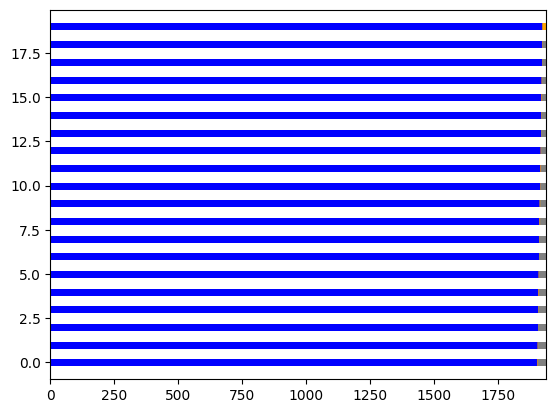

In [28]:
cutoff_values_for_cv = best_result.metrics["cutoff_values"]
test_size = best_result.config.get("test_size")
mse_per_split = best_result.metrics["mse"]
df = ds.to_pandas()
cutoff_idxs = [np.where(df["ds"] == ct)[0][0] for ct in cutoff_values_for_cv]
colors = np.array(["blue", "orange", "grey"])

import matplotlib.pyplot as plt
for i, cutoff_idx in enumerate(cutoff_idxs):
    dataset_idxs = np.arange(len(df))
    color_idxs = np.zeros_like(dataset_idxs)
    color_idxs[dataset_idxs >= cutoff_idx] = 1
    color_idxs[dataset_idxs > cutoff_idx + test_size] = 2
    plt.scatter(x=dataset_idxs, y=np.ones_like(dataset_idxs) * i, c=colors[color_idxs], marker="_", lw=5)
plt.xlim(0, len(df) - 1)

Let's visualize some predictions of the best model!

```diff
- TODO: statsforecast doesn't really fall into the `Trainer` and `Predictor` paradigm. Does it make sense to introduce a StatsforecastPredictor?
- There are sklearn style methods `fit` and `predict` which save the model, but cross validation is implemented like `fit_predict`, without saving the model in between
- Should the model predictions dataframe be saved? Currently, this code basically just reproduces the cross validation with the best result config
```

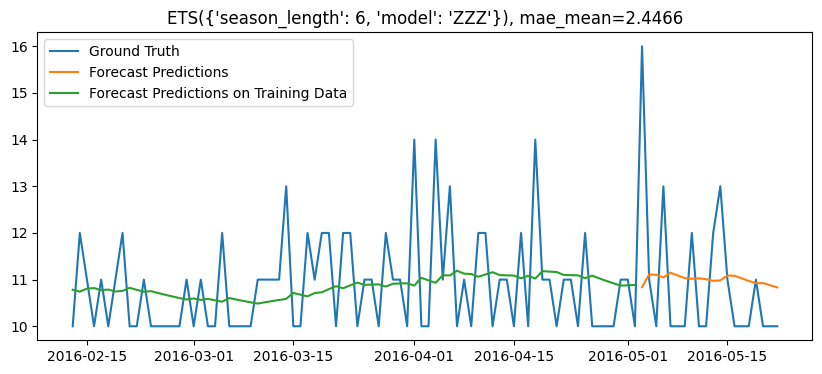

In [33]:
def plot_model_predictions_per_split(result, train_df):
#     model_cls, model_params = result.config["model_cls_and_params"]
#     model = model_cls(**model_params)

#     fcst = StatsForecast(
#         df=df, models=[model], freq="D", ray_address="auto", n_jobs=-1
#     )

#     test_size = result.config.get("test_size", 1)
# #     n_splits = result.config.get("n_splits", 20)
#     n_splits = 20

#     forecast_df = fcst.cross_validation(
#         h=test_size, n_windows=n_splits, step_size=test_size
#     )
    
    max_points_to_show = 100
    
    model_cls, model_params = result.config["model_cls_and_params"]
    checkpoint_dict = result.checkpoint.to_dict()
    forecast_df = checkpoint_dict["cross_validation_df"]
    train_forecast_df = checkpoint_dict["cross_validation_fitted_values_df"]
    plt.figure(figsize=(10, 4))
    # Only show the last 50 timesteps of the ground truth data
    plt.plot(
        train_df["ds"][-max_points_to_show:],
        train_df["y"][-max_points_to_show:],
        label="Ground Truth"
    )
    plt.plot(
        forecast_df["ds"],
        forecast_df[model_cls.__name__],
        label="Forecast Predictions"
    )
    test_df = train_forecast_df[train_forecast_df["cutoff"] == train_forecast_df["cutoff"].min()]
    plt.plot(
        test_df["ds"][-80:],
        test_df[model_cls.__name__][-80:],
        label="Forecast Predictions on Training Data"
    )
    plt.title(
        f"{model_cls.__name__}({model_params}), "
        f"mae_mean={result.metrics['mse_mean']:.4f}"
    )
    plt.legend()

    plt.show()

plot_model_predictions(best_result, df)

In [ ]:
def plot_model_predictions(result, df):
#     model_cls, model_params = result.config["model_cls_and_params"]
#     model = model_cls(**model_params)

#     fcst = StatsForecast(
#         df=df, models=[model], freq="D", ray_address="auto", n_jobs=-1
#     )

#     test_size = result.config.get("test_size", 1)
# #     n_splits = result.config.get("n_splits", 20)
#     n_splits = 20

#     forecast_df = fcst.cross_validation(
#         h=test_size, n_windows=n_splits, step_size=test_size
#     )
    
    model_cls, model_params = result.config["model_cls_and_params"]
    checkpoint_dict = result.checkpoint.to_dict()
    forecast_df = checkpoint_dict["cross_validation_df"]
    train_forecast_df = checkpoint_dict["cross_validation_fitted_values_df"]
    plt.figure(figsize=(10, 4))
    # Only show the last 50 timesteps of the ground truth data
    plt.plot(
        df["ds"][-100:],
        df["y"][-100:],
        label="Ground Truth"
    )
    plt.plot(
        forecast_df["ds"],
        forecast_df[model_cls.__name__],
        label="Forecast Predictions"
    )
tu
    plt.title(
        f"{model_cls.__name__}({model_params}), "
        f"mae_mean={result.metrics['mse_mean']:.4f}"
    )
    plt.legend()

    plt.show()
        

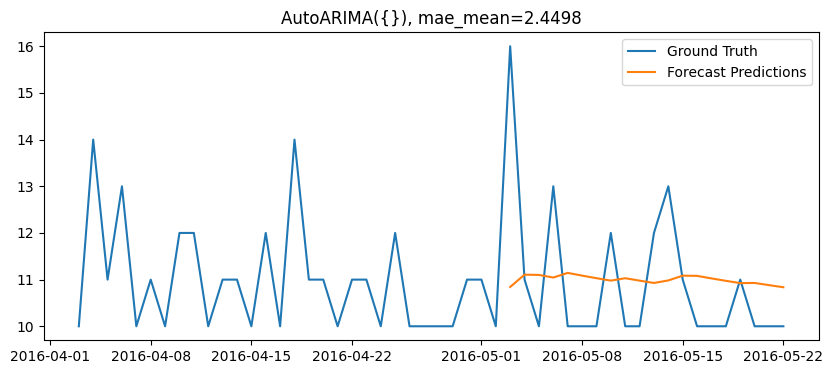

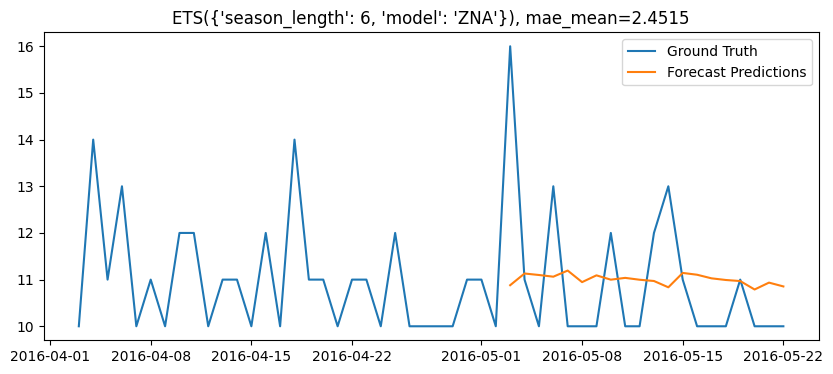

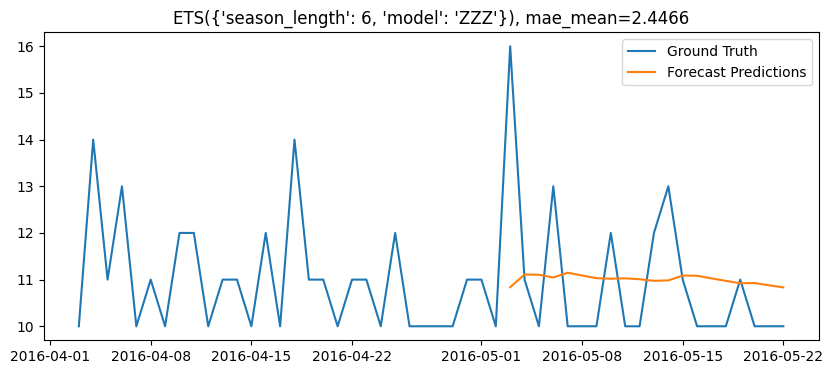

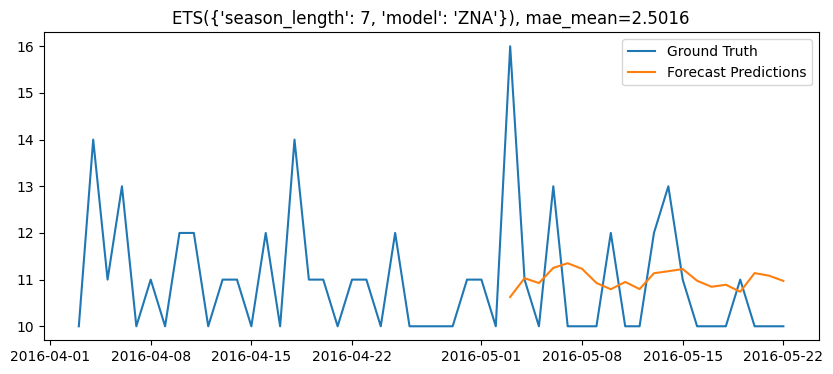

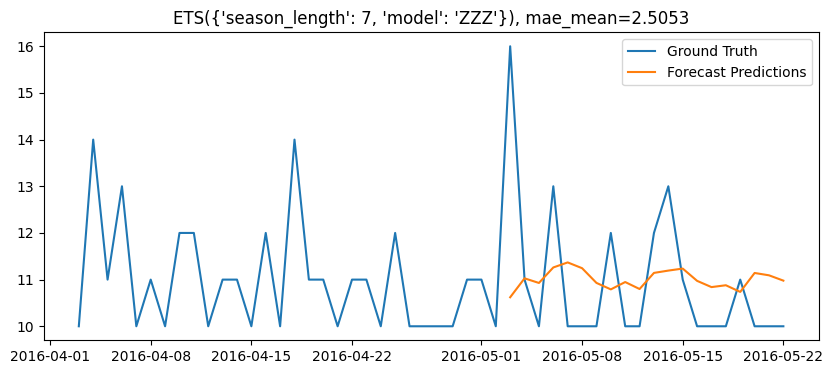

In [20]:
# Plot for all results
for result in result_grid:
    plot_model_predictions(result, df)

In [27]:
forecast_df

,ds,cutoff,y,ETS
unique_id,,,,
FOODS_1_001_CA_1,2016-05-18,2016-05-17,10.0,10.991765
FOODS_1_001_CA_1,2016-05-19,2016-05-18,11.0,10.969149
FOODS_1_001_CA_1,2016-05-20,2016-05-19,10.0,10.788298
FOODS_1_001_CA_1,2016-05-21,2016-05-20,10.0,10.935519
FOODS_1_001_CA_1,2016-05-22,2016-05-21,10.0,10.853874
